In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data_files = os.listdir('data')

data_frames = {}
for file in data_files:
    file_path = os.path.join('data', file)
    if file.endswith('.csv'):
        data_frames[file] = pd.read_csv(file_path)

In [3]:
cutoff_time = pd.Timestamp('2024-12-04 03:00:00', tz='UTC')

for file in data_files:
    if file.endswith('.csv'):
        data_frames[file]['time'] = pd.to_datetime(data_frames[file]['time']).dt.floor('s')
        data_frames[file] = data_frames[file][data_frames[file]['time'] >= cutoff_time]
        

In [4]:
for file in data_files:
    if file.endswith('.csv') and 'value' in data_frames[file].columns:
        data_frames[file].rename(columns={'value': f'value_{file.split(".")[0]}'}, inplace=True)

In [ ]:
on_change_cols = ['IOT_project-minimum_water_threshold.csv', 'IOT_project-need_water.csv', 'IOT_project-led_on.csv', 'IOT_project-minimum_light_threshold.csv']

# Initialize the merged dataframe with the first dataframe in the dictionary
merged_df = data_frames[data_files[0]]
merged_on_change_df = data_frames[on_change_cols[0]]

# Loop through the remaining dataframes and merge them on the 'time' column
for file in data_files[1:]:
    if file.endswith('.csv') and file not in on_change_cols:
        merged_df = pd.merge(merged_df, data_frames[file], on='time', suffixes=('', f'_{file.split(".")[0]}'))
    elif file in on_change_cols and file != on_change_cols[0]:
        merged_on_change_df = pd.merge(merged_on_change_df, data_frames[file], on='time', how='outer', suffixes=('', f'_{file.split(".")[0]}'))

print(merged_df.shape)
print(merged_on_change_df.shape)

(66457, 10)
(73474, 5)


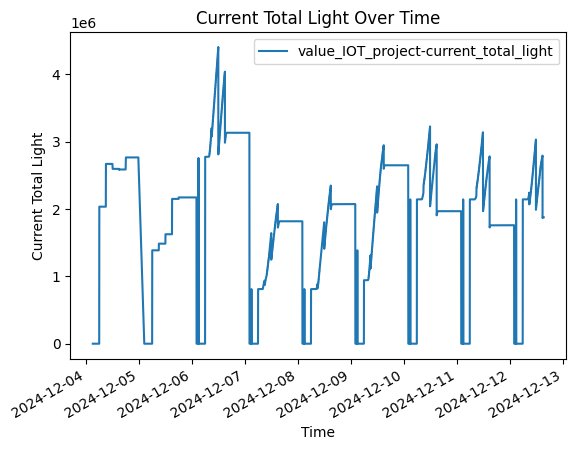

In [6]:
merged_df.plot(x='time', y='value_IOT_project-current_total_light', kind='line')
plt.xlabel('Time')
plt.ylabel('Current Total Light')
plt.title('Current Total Light Over Time')
plt.show()

In [7]:
print("Non-continous data:")
print(merged_on_change_df.isnull().sum())
print("\nContinous data:")
print(merged_df.isnull().sum())

Non-continous data:
time                                             0
value_IOT_project-minimum_water_threshold    73432
value_IOT_project-minimum_light_threshold      374
value_IOT_project-need_water                 73142
value_IOT_project-led_on                     73427
dtype: int64

Continous data:
time                                     0
value_IOT_project-internal_hum           0
value_IOT_project-current_total_light    0
value_IOT_project-total_light            0
value_IOT_project-outdoor_hum            0
value_IOT_project-light_value            0
value_IOT_project-outdoor_temp           0
value_IOT_project-predicted_light        0
value_IOT_project-internal_temp          0
value_IOT_project-soil_moisture          0
dtype: int64


In [8]:
merged_df_copy = merged_df.copy()

In [9]:
merged_df_copy['day_time'] = np.where((merged_df['time'].dt.hour >= 8) & (merged_df['time'].dt.hour <= 16), 1, 0)

In [10]:
merged_df_copy['day_time'].value_counts()

day_time
0    40142
1    26315
Name: count, dtype: int64

In [11]:
merged_df_copy.drop(columns=['time', 'value_IOT_project-predicted_light', 'value_IOT_project-total_light'], inplace=True)

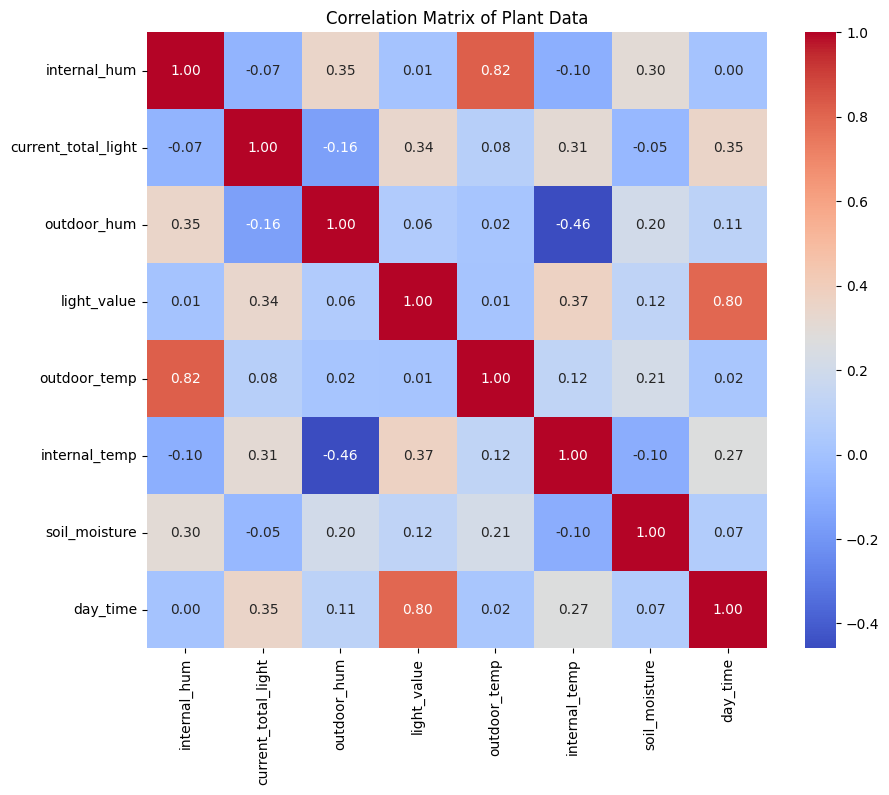

In [58]:
# Compute the correlation matrix
corr_matrix = merged_df_copy.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
# Remove 'value_IOT_project-' prefix from each variable name in the correlation matrix
corr_matrix.columns = corr_matrix.columns.str.replace('value_IOT_project-', '')
corr_matrix.index = corr_matrix.index.str.replace('value_IOT_project-', '')

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Plant Data')
plt.show()

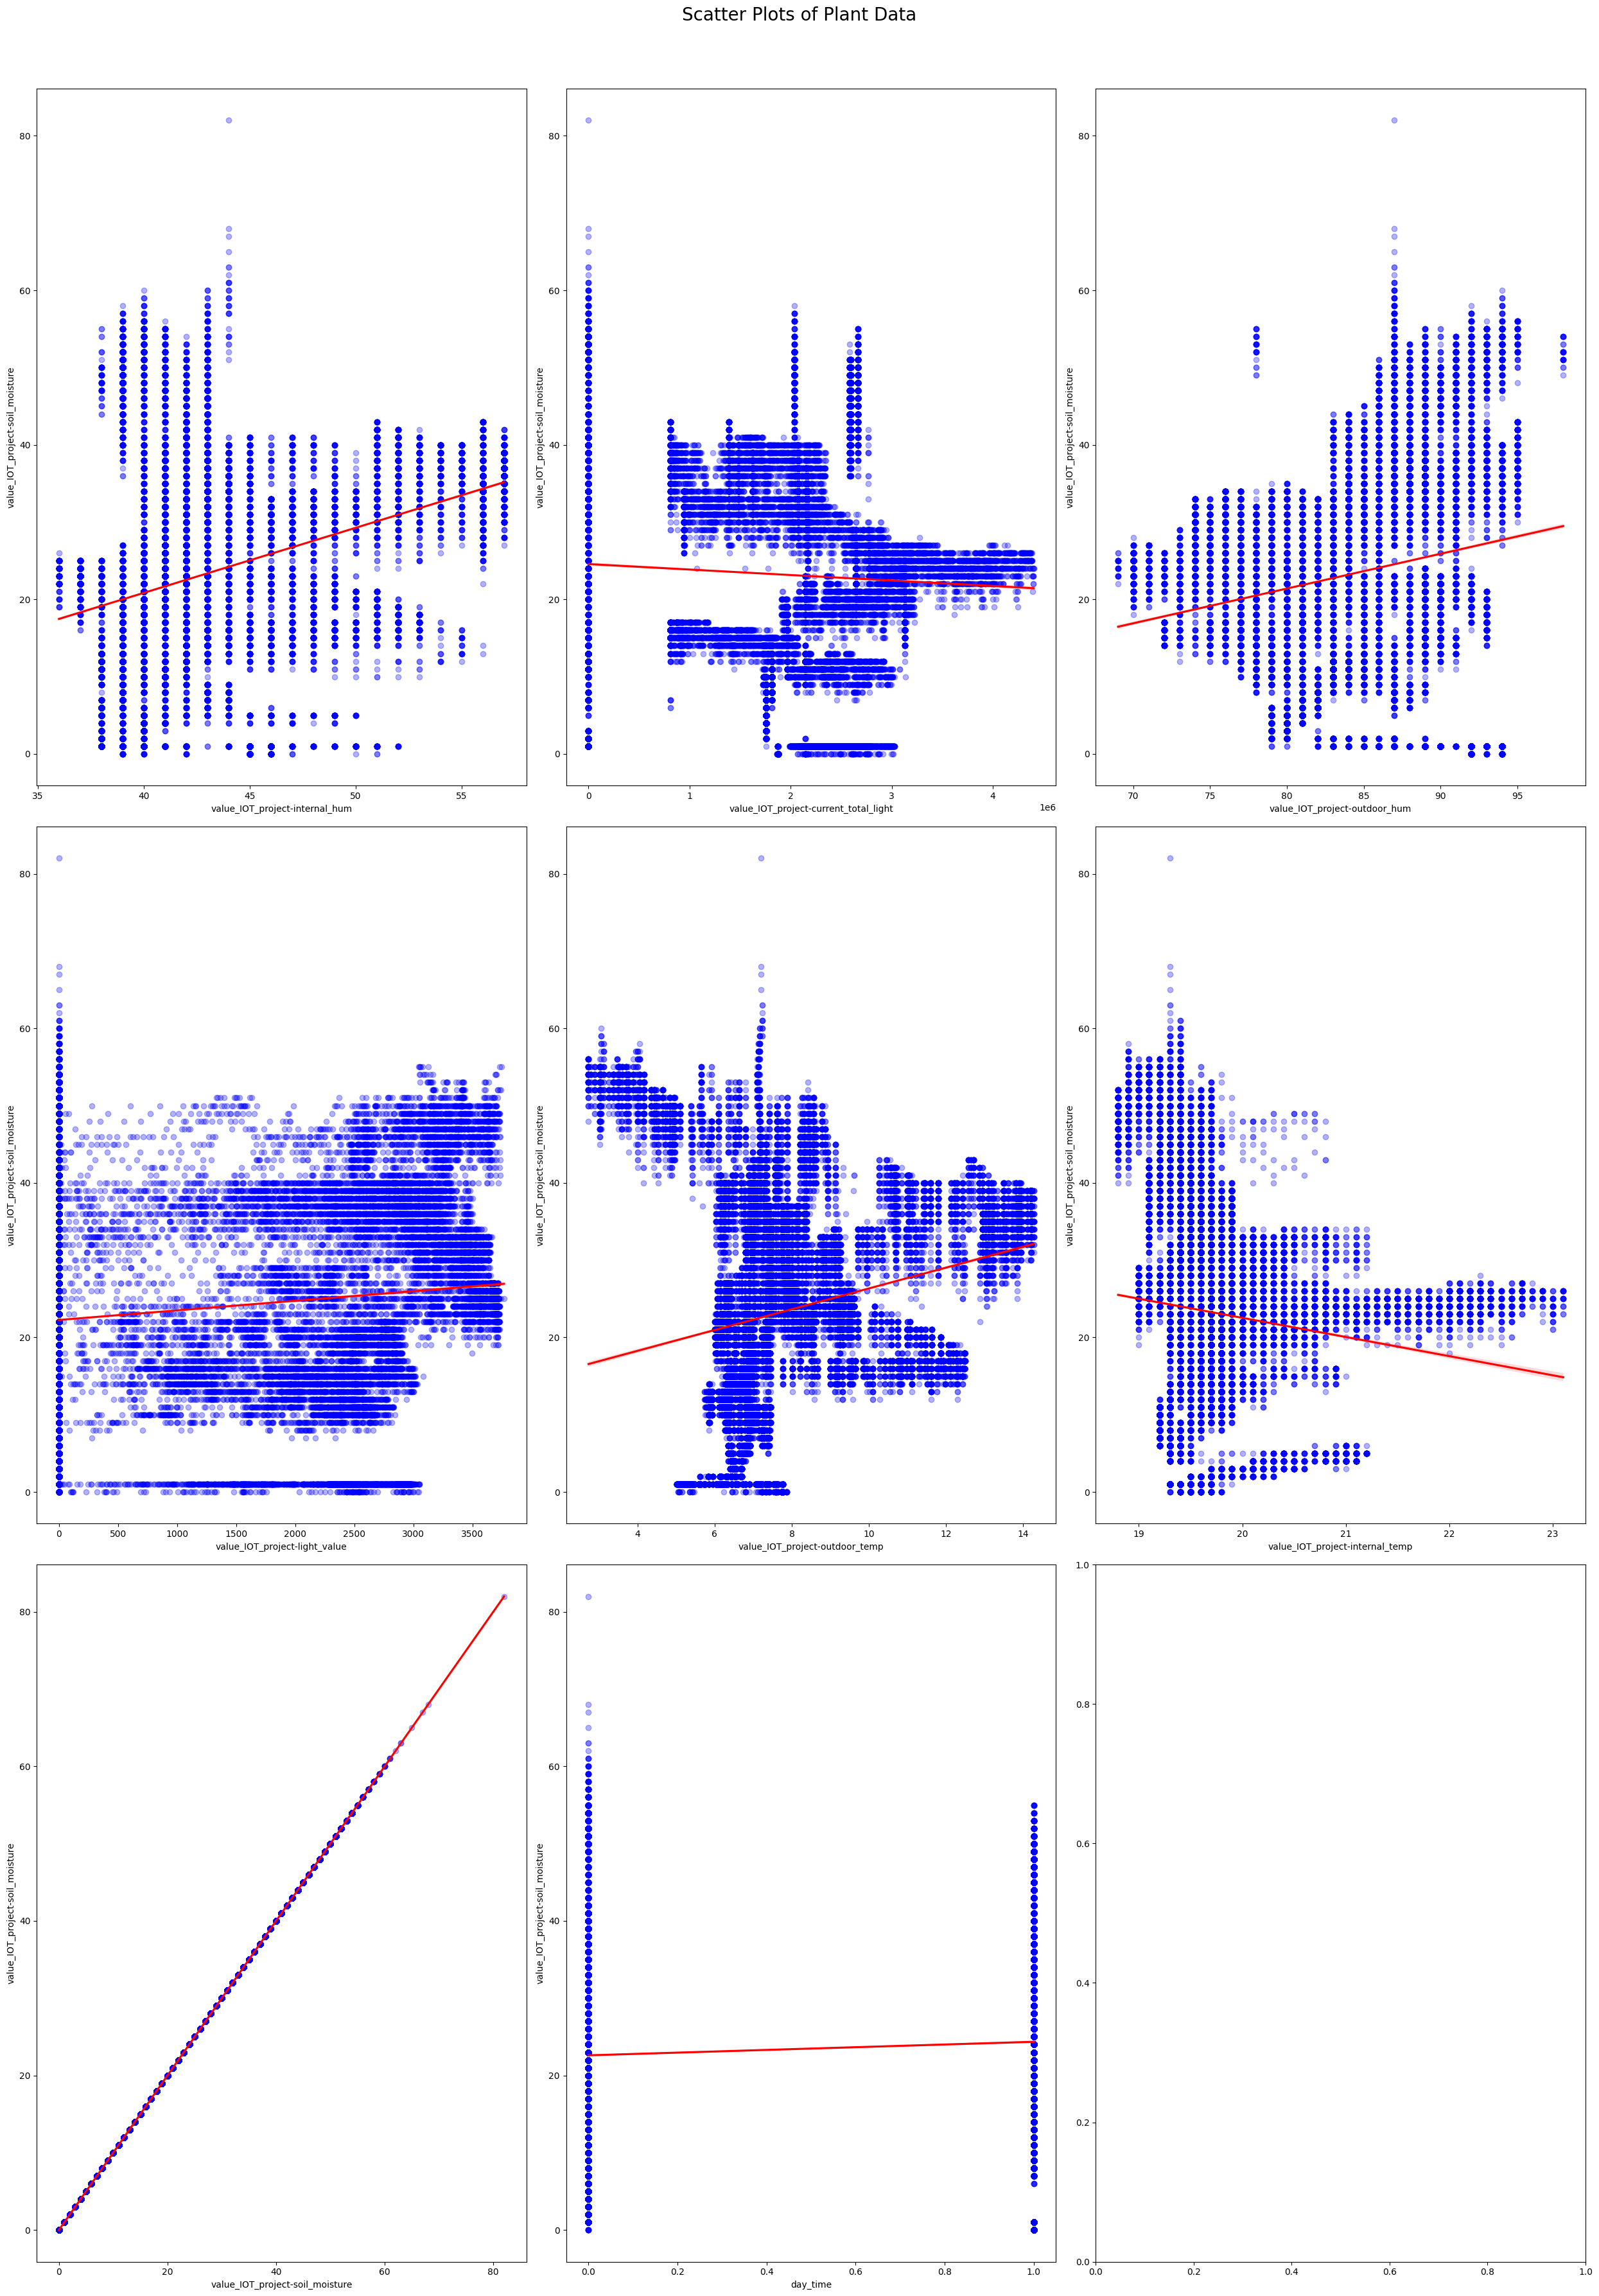

In [15]:
# Create the subplots
fig, axes = plt.subplots(nrows=3, ncols=3) 
fig.set_size_inches(25, 35)
n_cols = 3 # Define the number of columns
for i, column in enumerate(merged_df_copy.columns):
    sns.regplot(x=merged_df_copy[column], y=merged_df_copy['value_IOT_project-soil_moisture'], ax=axes[i//n_cols, i%n_cols], scatter=True, color='blue', scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'}) 
fig.suptitle('Scatter Plots of Plant Data', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

In [16]:
# Define the split point (e.g., 70% of the data for training)
split_point = int(len(merged_df_copy) * 0.7)

# Split the data into training and testing sets
train_df = merged_df_copy.iloc[:split_point]
test_df = merged_df_copy.iloc[split_point:]

# Define the features and target variable
X_train = train_df.drop(columns=['value_IOT_project-soil_moisture', 'day_time'])
y_train = train_df['value_IOT_project-soil_moisture']
X_test = test_df.drop(columns=['value_IOT_project-soil_moisture', 'day_time'])
y_test = test_df['value_IOT_project-soil_moisture']

print(f'Training set size: {len(train_df)}')
print(f'Testing set size: {len(test_df)}')

Training set size: 46519
Testing set size: 19938


In [ ]:
# Make predictions using the non-linear model
non_linear_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,  # Limit depth
    min_samples_split=10,  # Require a minimum number of samples per split
    random_state=42
)
non_linear_model.fit(X_train, y_train)

# Evaluate the model
y_pred_soil_moisture = non_linear_model.predict(X_train)
mse_soil_moisture_train = mean_squared_error(y_train, y_pred_soil_moisture)
r2_soil_moisture_train = r2_score(y_train, y_pred_soil_moisture)

y_pred_soil_moisture = non_linear_model.predict(X_test)
mse_soil_moisture_test = mean_squared_error(y_test, y_pred_soil_moisture)
r2_soil_moisture_test = r2_score(y_test, y_pred_soil_moisture)

print(f'Train Soil Moisture Prediction Mean Squared Error: {mse_soil_moisture_train}')
print(f'Train Soil Moisture Prediction R^2 Score: {r2_soil_moisture_train}')
print(f'Test Soil Moisture Prediction Mean Squared Error: {mse_soil_moisture_test}')
print(f'Test Soil Moisture Prediction R^2 Score: {r2_soil_moisture_test}')

Train Soil Moisture Prediction Mean Squared Error: 4.30582825234713
Train Soil Moisture Prediction R^2 Score: 0.9640282744502277
Test Soil Moisture Prediction Mean Squared Error: 590.0715697023983
Test Soil Moisture Prediction R^2 Score: -10.840381516144742


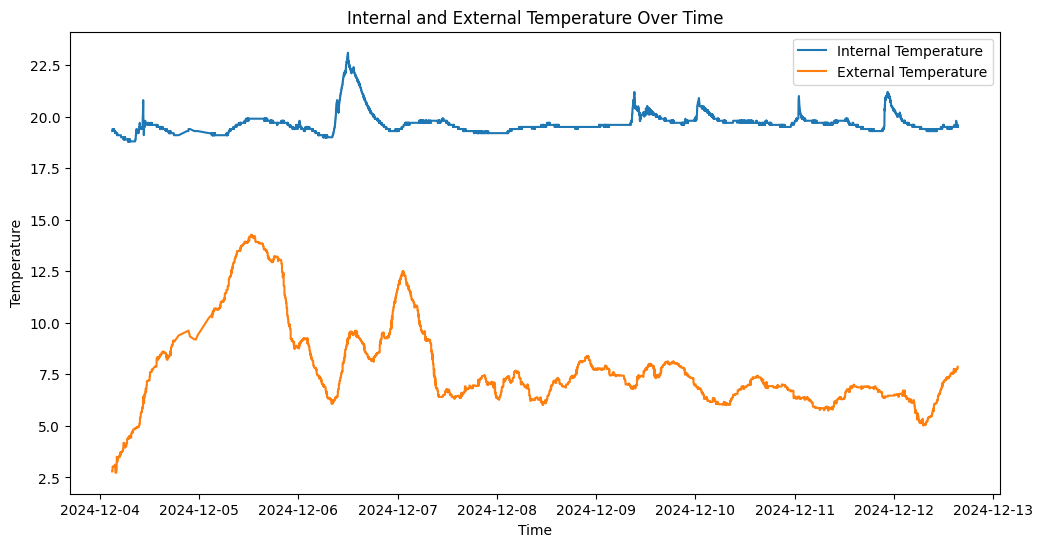

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['time'], merged_df['value_IOT_project-internal_temp'], label='Internal Temperature')
plt.plot(merged_df['time'], merged_df['value_IOT_project-outdoor_temp'], label='External Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Internal and External Temperature Over Time')
plt.legend()
plt.show()

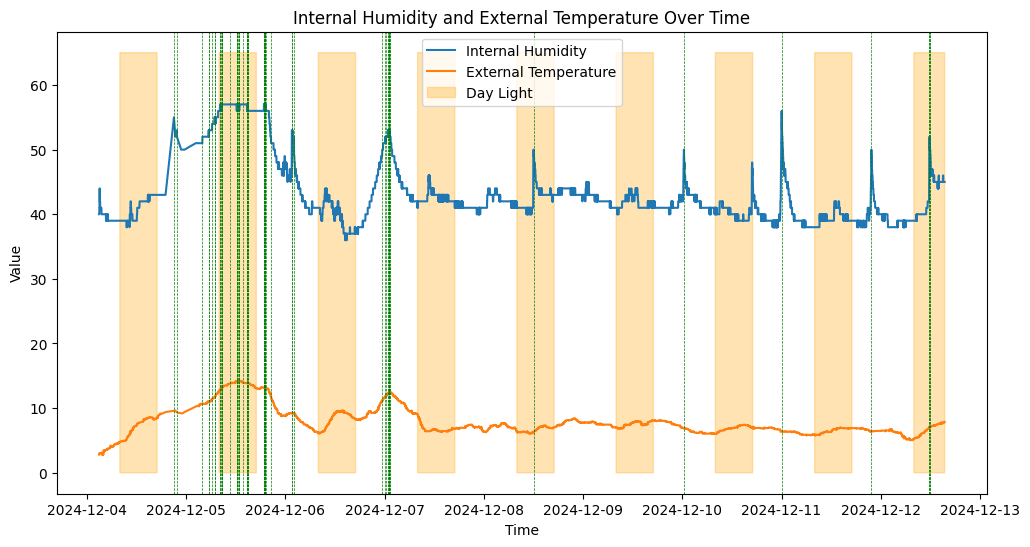

In [ ]:
from scipy.signal import find_peaks

plt.figure(figsize=(12, 6))
plt.plot(merged_df['time'], merged_df['value_IOT_project-internal_hum'], label='Internal Humidity')
plt.plot(merged_df['time'], merged_df['value_IOT_project-outdoor_temp'], label='External Temperature')
plt.fill_between(merged_df['time'], 0, 65, where=merged_df_copy['day_time'] == 1, color='orange', alpha=0.3, label='Day Light')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Internal Humidity and External Temperature Over Time')
peaks, properties = find_peaks(merged_df['value_IOT_project-internal_hum'], height=40)
big_peaks = peaks[properties['peak_heights'] > 49]
for peak in big_peaks:
    plt.axvline(merged_df['time'].iloc[peak], color='green', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

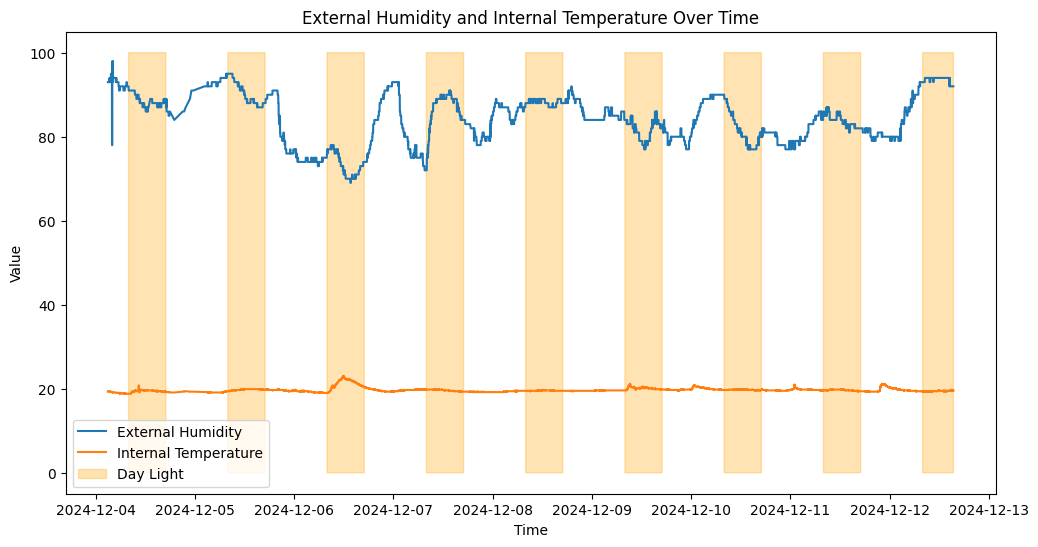

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['time'], merged_df['value_IOT_project-outdoor_hum'], label='External Humidity')
plt.plot(merged_df['time'], merged_df['value_IOT_project-internal_temp'], label='Internal Temperature')
plt.fill_between(merged_df['time'], 0, 100, where=merged_df_copy['day_time'] == 1, color='orange', alpha=0.3, label='Day Light')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('External Humidity and Internal Temperature Over Time')
plt.legend()
plt.show()

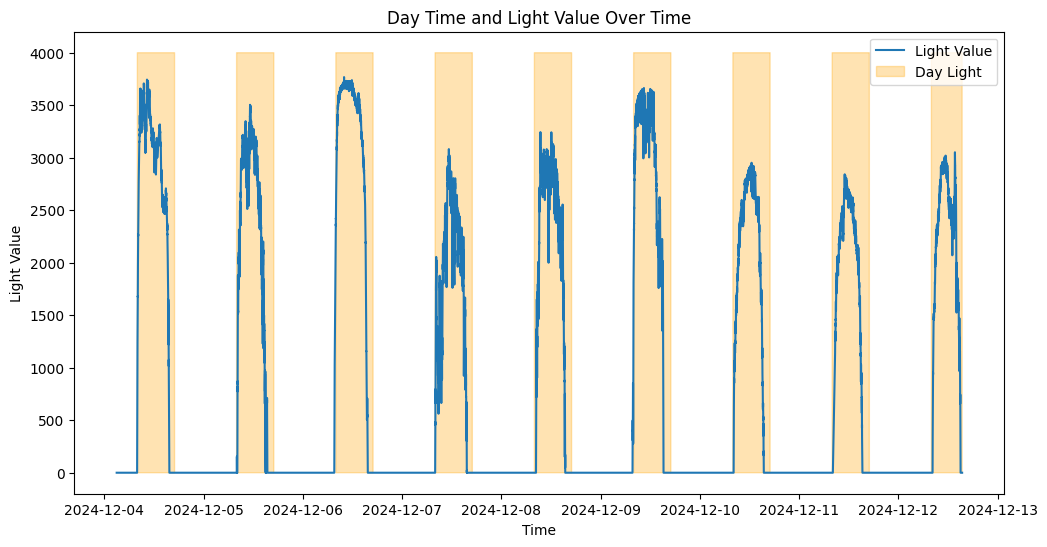

In [30]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(merged_df['time'], merged_df_copy['value_IOT_project-light_value'], label='Light Value')
#plt.plot(merged_df_copy['value_IOT_project-soil_moisture']*10, label='Soil Moisture', color='green')
plt.xlabel('Time')
plt.ylabel('Light Value')
plt.title('Day Time and Light Value Over Time')
plt.fill_between(merged_df['time'], 0, 4000, where=merged_df_copy['day_time'] == 1, color='orange', alpha=0.3, label='Day Light')
plt.legend()
# Set xticks to show only one tick per day
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gcf().autofmt_xdate()
plt.show()

In [62]:
from statsmodels.tsa.stattools import grangercausalitytests

# Perform Granger Causality test
grangercausalitytests(merged_df_copy[['value_IOT_project-soil_moisture', 'value_IOT_project-internal_hum']], maxlag=5)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=35.0147 , p=0.0000  , df_denom=66453, df_num=1
ssr based chi2 test:   chi2=35.0163 , p=0.0000  , df=1
likelihood ratio test: chi2=35.0070 , p=0.0000  , df=1
parameter F test:         F=35.0147 , p=0.0000  , df_denom=66453, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1564  , p=0.0021  , df_denom=66450, df_num=2
ssr based chi2 test:   chi2=12.3136 , p=0.0021  , df=2
likelihood ratio test: chi2=12.3125 , p=0.0021  , df=2
parameter F test:         F=6.1564  , p=0.0021  , df_denom=66450, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3939  , p=0.0171  , df_denom=66447, df_num=3
ssr based chi2 test:   chi2=10.1827 , p=0.0171  , df=3
likelihood ratio test: chi2=10.1820 , p=0.0171  , df=3
parameter F test:         F=3.3939  , p=0.0171  , df_denom=66447, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4152  

{1: ({'ssr_ftest': (35.01468993224241, 3.2882516242816422e-09, 66453.0, 1),
   'ssr_chi2test': (35.016270659520295, 3.26961782426029e-09, 1),
   'lrtest': (35.007048706524074, 3.285139611538899e-09, 1),
   'params_ftest': (35.01468993584567, 3.288251618185943e-09, 66453.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (6.156354789890561, 0.0021211762779355433, 66450.0, 2),
   'ssr_chi2test': (12.313636044008344, 0.002118985119781176, 2),
   'lrtest': (12.312495375634171, 0.0021201939941353325, 2),
   'params_ftest': (6.156354792418917, 0.002121176272574824, 66450.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (3.393887577052746, 0.01708891778334511, 66447.0, 3),
   'ssr_chi2test': (10.182735339991115, 0.01707500853990423, 3),
   'lrtest': (10.181955278618261, 0.01708111647707679, 3),
   'params_ftest': (3.3938875798093444, 0.017088917718572884, 66447.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1.

In [61]:
# Perform Granger Causality test
grangercausalitytests(merged_df_copy[['value_IOT_project-internal_hum', 'value_IOT_project-soil_moisture']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6567  , p=0.1980  , df_denom=66453, df_num=1
ssr based chi2 test:   chi2=1.6568  , p=0.1980  , df=1
likelihood ratio test: chi2=1.6568  , p=0.1980  , df=1
parameter F test:         F=1.6567  , p=0.1980  , df_denom=66453, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5440  , p=0.5804  , df_denom=66450, df_num=2
ssr based chi2 test:   chi2=1.0881  , p=0.5804  , df=2
likelihood ratio test: chi2=1.0881  , p=0.5804  , df=2
parameter F test:         F=0.5440  , p=0.5804  , df_denom=66450, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9377  , p=0.1211  , df_denom=66447, df_num=3
ssr based chi2 test:   chi2=5.8136  , p=0.1210  , df=3
likelihood ratio test: chi2=5.8134  , p=0.1211  , df=3
parameter F test:         F=1.9377  , p=0.1211  , df_denom=66447, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6774  

{1: ({'ssr_ftest': (1.6567406479728521, 0.19804845337249, 66453.0, 1),
   'ssr_chi2test': (1.6568154410137068, 0.19803384570934088, 1),
   'lrtest': (1.6567947816220112, 0.19803664225055462, 1),
   'params_ftest': (1.6567406407589824, 0.19804845434943286, 66453.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.5440226451713397, 0.5804113565888931, 66450.0, 2),
   'ssr_chi2test': (1.0881271598152409, 0.580385013142122, 2),
   'lrtest': (1.0881182510056533, 0.580387598417665, 2),
   'params_ftest': (0.5440226441065036, 0.5804113572055026, 66450.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.9376775072985746, 0.1210805769417599, 66447.0, 3),
   'ssr_chi2test': (5.813644908123142, 0.12103731151673731, 3),
   'lrtest': (5.813390609109774, 0.12105068008510543, 3),
   'params_ftest': (1.9376775027095325, 0.12108057766585957, 66447.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [

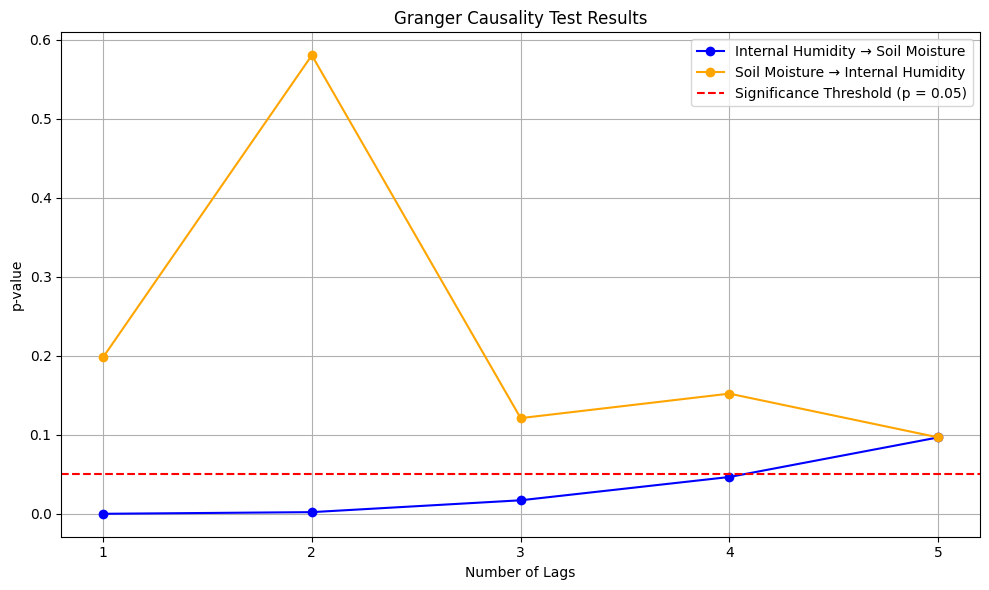

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# P-values for both directions
forward_p_values = [0.0000, 0.0021, 0.0171, 0.0466, 0.0967]  # From humidity to Soil Moisture
reverse_p_values = [0.1980, 0.5804, 0.1211, 0.1521, 0.0967]  # From Soil Moisture to humidity

# Lags
lags = np.arange(1, 6)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(lags, forward_p_values, marker='o', label='Internal Humidity → Soil Moisture', color='blue')
plt.plot(lags, reverse_p_values, marker='o', label='Soil Moisture → Internal Humidity', color='orange')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p = 0.05)')

# Labels and legend
plt.title('Granger Causality Test Results')
plt.xlabel('Number of Lags')
plt.ylabel('p-value')
plt.xticks(lags)
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()